In [ ]:
!pip install tableone

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re
from tableone import TableOne



url = '/content/drive/MyDrive/Proyecto Alto Cafe Clustering/REGISTRO DE SERVICIOS ALFONZO.xls'

df = pd.read_excel(url, usecols= ['Cant adultos', 'Cant niños', 'Monto', 'Propinas'], nrows= 3058, engine = None )

df.head()

,Monto,Propinas,Cant adultos,Cant niños
0,36,4,4,N-A
1,16,2,2,N-A
2,12,0,3,N-A
3,20,0,2,N-A
4,5,0,2,N-A


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Monto         3057 non-null   object
 1   Propinas      3057 non-null   object
 2   Cant adultos  3057 non-null   object
 3   Cant niños    3057 non-null   object
dtypes: object(4)
memory usage: 95.7+ KB


In [ ]:
# Reemplazar 'N-A' con NaN (Not a Number)
df = df.replace('N-A', np.nan)

# Eliminar filas que contienen NaN
df = df.dropna()

<ipython-input-37-efd930311741>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('N-A', np.nan)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2815 entries, 221 to 3053
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Monto         2815 non-null   float64
 1   Propinas      2815 non-null   float64
 2   Cant adultos  2815 non-null   float64
 3   Cant niños    2815 non-null   float64
dtypes: float64(4)
memory usage: 110.0 KB


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df['Monto'].describe()

,Monto
count,2815.000000
mean,23.160797
std,22.039583
min,1.000000
25%,8.990000
50%,16.980000
75%,30.000000
max,241.880000


In [ ]:
df.corr()

,Monto,Propinas,Cant adultos,Cant niños
Monto,1.000000,0.778104,0.447286,0.329913
Propinas,0.778104,1.000000,0.317665,0.240939
Cant adultos,0.447286,0.317665,1.000000,0.158061
Cant niños,0.329913,0.240939,0.158061,1.000000


In [ ]:
for col in df.columns:
    x = df[col]
    shapiro_test = stats.shapiro(x)
    print(f"Test de Shapiro para la columna '{col}':")
    print(shapiro_test)


Test de Shapiro para la columna 'Monto':
ShapiroResult(statistic=0.7762047827477767, pvalue=2.800218000416363e-52)
Test de Shapiro para la columna 'Propinas':
ShapiroResult(statistic=0.7173638100551126, pvalue=2.46690656792503e-56)
Test de Shapiro para la columna 'Cant adultos':
ShapiroResult(statistic=0.6287782541715935, pvalue=2.871507462052009e-61)
Test de Shapiro para la columna 'Cant niños':
ShapiroResult(statistic=0.6531300740769437, pvalue=5.080886376350159e-60)


In [ ]:
# Inicializar MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
df_scaled

,Monto,Propinas,Cant adultos,Cant niños
0,0.203421,0.000000,0.061224,0.1
1,0.041514,0.000000,0.040816,0.1
2,0.099635,0.000000,0.040816,0.3
3,0.618565,0.060386,0.102041,0.0
4,0.273995,0.000000,0.081633,0.4
...,...,...,...,...
2810,0.099510,0.075181,0.040816,0.0
2811,0.093324,0.070652,0.020408,0.2
2812,0.020716,0.018086,0.061224,0.2
2813,0.008261,0.008756,0.061224,0.1


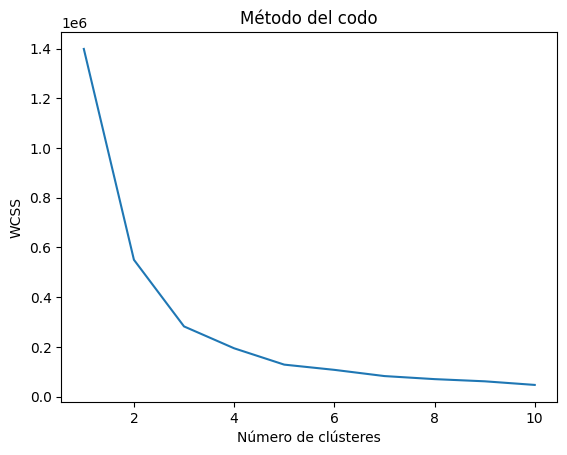

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Método del codo')
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')
plt.show()

In [ ]:
model = KMeans(n_clusters = 3, random_state = 42)
model.fit(df_scaled)

df_scaled['Cluster'] = model.predict(df_scaled)
df['Cluster'] = df_scaled['Cluster']

In [ ]:
df['Cluster'].value_counts()

,count
Cluster,
0,2124
1,478
2,213


In [ ]:
def is_binary(df_, nums):
    df = df_.copy()
    variables = []
    for var in nums:
        flag = True
        unique = df_[var].unique()
        for value in unique:
            if value not in [0, 1, np.nan, 0.0, 1.0]:
                flag = False
        if flag == True:
            variables.append(var)
    return variables


def breakdown_vars(df):
    """
    This function allow us categorize accodign to numerical or not
    """
    categorial = []
    nonormal = []
    normal = []
    binaries = is_binary(df, df.columns)
    for t in df.columns:
            if (df[t].dtypes.name=="object" or df[t].dtypes.name=='category') and t not in binaries:
                categorial.append(t)
            if (df[t].dtypes=="int64" or df[t].dtypes=="float64") and t not in binaries:
              n,p = stats.shapiro(df[t])
              if p<0.05:
                nonormal.append(t)
              else:
                normal.append(t)
    return categorial, binaries, nonormal, normal

In [ ]:
categorial, binaries, nonormal, normal = breakdown_vars(df)

In [ ]:
mytable = TableOne(df,
                   categorical=categorial,
                   nonnormal=nonormal,
                   groupby= 'Cluster',
                   pval=True)

In [ ]:
mytable

Grouped by Cluster                                                                              
                                         Missing          Overall                0                 1                 2 P-Value
n                                                            2815             2124               478               213        
Monto, median [Q1,Q3]                          0  17.0 [9.0,30.0]  14.0 [7.0,24.0]  24.0 [14.9,36.0]  73.0 [59.0,90.0]  <0.001
Propinas, median [Q1,Q3]                       0    1.0 [0.0,2.5]    0.9 [0.0,2.0]     1.7 [0.0,3.1]     7.4 [5.7,9.1]  <0.001
Cant adultos, median [Q1,Q3]                   0    2.0 [2.0,4.0]    2.0 [2.0,3.0]     3.0 [2.0,4.0]     4.0 [3.0,6.0]  <0.001
Cant niños, median [Q1,Q3]                     0    0.0 [0.0,1.0]    0.0 [0.0,0.0]     2.0 [2.0,3.0]     1.0 [0.0,2.0]  <0.001

In [ ]:
#SE DETECTARON 3 GRUPOS RELEVANTES ENTRE LOS SERVICIOS DE ALTO CAFE DE UNA MUESTRA DE 2815 SERVICIOS
#75% DE LOS SERVICIOS SE REALIZARON A PAREJAS
#17% DE LOS SERVICIOS SE REALIZARON A FAMILIAS
#8% DE LOS SERVICIOS SE REALIZARON A GRUPOS DE AMIGOS
#SE OBSERVA QUE EL PRINCIPAL CLIENTE SON PAREJAS, SEGUIDOS DE FAMILIAS, SEGUIDOS DE GRUPOS DE AMIGOS.

In [ ]:
df.groupby('Cluster').sum()

,Monto,Propinas,Cant adultos,Cant niños
Cluster,,,,
0,35613.977,2532.8998,5696.0,414.0
1,12878.218,911.8530,1571.0,1204.0
2,16705.448,1644.2270,1115.0,284.0


In [ ]:
df['Monto'].sum() #total de gasto en muestra 65197.643000000004


65197.643000000004

In [ ]:
#GRUPO 0 CORRESPONDE A 54% DE VENTAS
#GRUPO 1 CORRESPONDE A 20% DE VENTAS
#GRUPO 2 CORRESPONDE A 26% DE VENTAS